# Кредитный скоринг

В задаче кредитного скоринга чаще всего применяется логистическа регрессия, как алгоритм извлечения зависимости.  
Из-за линейности модели важным является отбор и преобразования признаков.  
В данном ноутбуке мы рассмотрим несколько подходов к преобразования признаков.

---
# Загружаем выборку с данными

Выборка содержит заявки на кредит и поля:
* `application_date` - дата обработки заявки
* `default_flg` - факт наличия дефолта
* `f*, v*, d*` - признаки заявки

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

df = pd.read_csv('credit_scoring.csv', parse_dates=['application_date'])
df.head()

,application_date,default_flg,f1,f2,f3,f4,v1,v2,v3,d1,d2
0,2016-04-15,False,32.0,0,0.21188,40000.0,510.637947,44156.693747,2.0,0.376852,0.735676
1,2016-03-17,False,41.0,0,0.14440,50000.0,5050.136084,27141.827128,2.0,-0.391030,0.487837
2,2016-01-22,False,32.0,0,0.11931,20000.0,1129.085126,18951.450273,0.0,-0.159463,0.649534
3,2016-05-10,False,32.0,1,0.32720,50000.0,365.786200,16209.919629,-1.0,-0.289004,0.202991
4,2016-09-03,False,20.0,0,0.38527,20000.0,382.670122,31207.425740,0.0,-0.189657,0.000000


Мы будем извлекать зависимость между признаками и целевой переменной.   
Для валидации модели необходимо разбить выборку на две части по дате обработки заявки:
* обучающая выборка - заявки с датой подачи заявки ранее '2016-05-01'
* тестовая выборка - заявки с датой подачи начиная с '2016-05-01'

**Задание 1. Разбейте выборку на две части и посчитайте количество объектов в каждой выборке**

In [2]:
features = ['f1','f2','f3','f4','v1','v2', 'v3','d1', 'd2']

X_train = df.query('application_date <= "2016-05-01"')[features]
X_test = df.query('application_date > "2016-05-01"')[features]

y_train = df.query('application_date <= "2016-05-01"')['default_flg']
y_test = df.query('application_date > "2016-05-01"')['default_flg']

print('Обучающая выборка: ', len(X_train))
print('Тестовая выборка : ', len(X_test))

Обучающая выборка:  202439
Тестовая выборка :  106812


---
# Подбор коэффициента регуляризации для логистической регресии

Для извлечения зависимости будем использовать [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) с l2 регуляризацией.  

**Задание 2.**  
    Переберите коэффициент регуляризации в интервале от $10^{-3}$ до $10^{3}$.  
    Постройте график зависимости качества AUC на тестовой выборке от коэфиициента регуляризации и найдите оптимальное значение.

AUC    0.665454
dtype: float64
Best C:  0.01


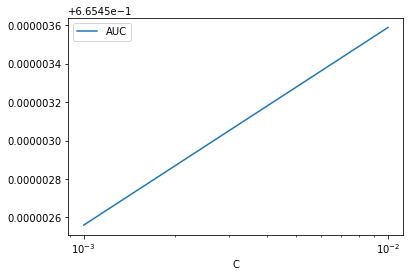

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))


for C in [0.001, 0.01]: # Здесь нужно указать больший набор перебираемых параметров
    clf = LogisticRegression(C=C)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics.loc[C] = auc

print(metrics.max())
C_best = metrics.AUC.idxmax()
print('Best C: ', C_best)
metrics.plot(logx=True);

---
# Нормализация признаков

Так как l2 регуляризация одинакого штрафует все признаки, то имеет смысл нормировать их все таким образом, чтобы стандартное отклонение равнялось 1 у всех признаков. Для этого можно воспользоваться [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Нормализовывать признаки стоит исходя из обучающей выборки, чтобы избегать переобучения.  
Для удобства трансформирования выборки В scikit-learn есть объекты [transformation](http://scikit-learn.org/stable/data_transforms.html), которые только преобразуют наборы признаков.  

Так же есть возможность объединять трансформации и модель в единый [пайплайн](http://scikit-learn.org/stable/modules/pipeline.html)
```python
classificator = Pipeline([
  ('name_transformation_1', Transformator_1),
  ...
  ('name_transformation_k', Transformator_k),
  ('name_classificator', Classifier)
])
```

При обучении будут подряд обучаться и применятся трансформаторы Transformator_1 ... Transformator_k, а затем на полученных признаках обучаться модель.  
Данный подход удобен тем, что позволяет не изменять исходные выборки признаков и избежать ошибки с дублированием преобразований для обучающей и тестовой выборках.


**Задание 3.**  

  Произведите нормализацию признаков и опять подберите коэфиициент C.  
  Каким образом изменилось качество на тестовой выборке?  
  Запомните лучшее значение коэффициента регуляризации и затем используйте его.

AUC    0.779493
dtype: float64
Best C:  0.01


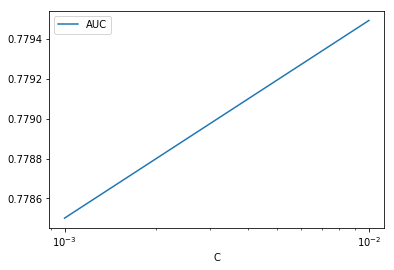

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

for C in [0.001, 0.01]: # Здесь нужно указать больший набор перебираемых параметров
    clf = Pipeline([
        ('scaller', StandardScaler()),
        ('model', LogisticRegression(C=C)),
    ])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    metrics.loc[C] = auc

print(metrics.max())
C_best = metrics.AUC.idxmax()
print('Best C: ', C_best)
metrics.plot(logx=True);

---
# Нормализация WoE

Влияние некоторых признаков на целеуцю переменную может быть нелинейное с точки зрения WoE.  
Поэтому имеет смысл преобразовать признаки таким образом, чтобы зависимость стала линейна.

**Задание 4.**  
  Преобразуйте часть признаков таким образом, чтобы график зависимости WoE стал более линейным.  
  Посчитайте качество логистической регрессии после такой нормализации.

In [5]:
def woe_line(feature, target, num_bucket=10):
    """Подсчет зависимости WoE от среднего значения признака в бакете"""
    from scipy.special import logit
    
    data = pd.DataFrame({'target': target, 'feature': feature})
    data['bucket'] = pd.qcut(feature, q=num_bucket, duplicates='drop')
    data['obj_count'] = 1
    
    target_mean = data['target'].mean()
    total_count = data['obj_count'].sum()
    
    data_agg = data.groupby('bucket').agg({'target': 'mean', 'feature': 'mean', 'obj_count': 'sum'})
    
    data_agg['target'] = np.clip(data_agg['target'], 0.001, 0.999)
    data_agg['woe'] = logit(data_agg['target']) - logit(target_mean)
    
    return data_agg.set_index('feature')['woe']

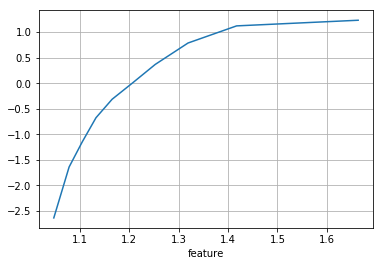

In [6]:
# Пример рисования зависимости woe от значений признака exp(f3)
woe_line( np.exp(X_train['f3']) , y_train).plot(grid=True);

In [7]:
from sklearn.preprocessing import FunctionTransformer


def feature_modification(X):
    """Функция модифицирования признаков 
       
       Если встраивать в pipeline, то на вход получает numpy.array,
       поэтому нужно обращаться к столбцам по индексу,
       как к элементам df.values
    """
    feature_matrix = np.array(X).copy()
    # Здесь нужно вставить преобразования признаков
    
    # Пример преобразования второго по индексу признака ('f3')
    feature_matrix[:, 2] = np.exp(feature_matrix[:, 2])
    
    return feature_matrix


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))

clf = Pipeline([
    ('woe_line_modification', FunctionTransformer(feature_modification)),
    ('scaller', StandardScaler()),
    ('model', LogisticRegression(C=C_best)),
])
    
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(auc)

0.769115941417


---
# Стабильность признаков

Так как мы используем валидацию по времени, то некоторые пизнаки могут оказаться нестабильными и сильно изменять свое распределение.  
Иногда исключение данных признаков из обучения положительно сказывается на качестве модели на отложенной выборке.

**Задание 5.**  
  Произвести анализ стабильности распределений признаков по времени. Попытаться выделить нестабильные признаки.  
  Посчитать качество модели с исключенными нестабильными признаки.

In [8]:
def plot_distribution_stability(feature, date, num_buck=10, date_freq='M'):
    """Рисуем изменение распределения признака по времени"""
    df = pd.DataFrame({'feature': feature, 'date': date})
    df['feature_buck'] = pd.qcut(feature, q=num_buck, duplicates='drop')
    df_agg = df.groupby([pd.Grouper(key='date', freq=date_freq), 'feature_buck']).size().unstack()
    df_agg = df_agg.apply(lambda x: x / df_agg.sum(axis=1))
    df_agg.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1, 1))

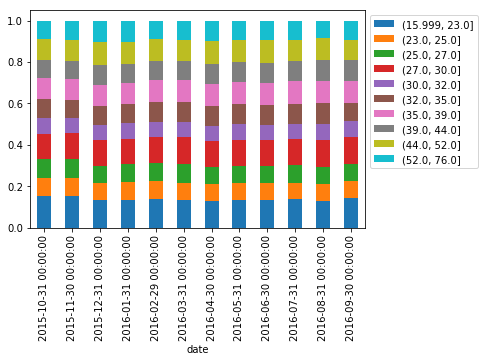

In [9]:
# Пример рисования изменения распределения у признака 'f1'
plot_distribution_stability(df['f1'], df['application_date'])

In [10]:
def keep_features(X):
    """Функция отбрасывания части признаков
       
       Если встраивать в pipeline, то на вход получает numpy.array,
       поэтому нужно обращаться к столбцам по индексу,
       как к элементам pd.DataFrame.values
    """
    # Здесь нужно указать список номеров признаков, которые будут использоваться в модели
    
    # Пример, когда используется только два первых признака
    features_index = [0, 1]
        
    return np.array(X)[:, features_index]


metrics = pd.DataFrame(columns=['AUC'], index=pd.Series(name='C'))


clf = Pipeline([
    ('woe_line_modification', FunctionTransformer(feature_modification)),
    ('keep_features', FunctionTransformer(keep_features)),
    ('scaller', StandardScaler()),
    ('model', LogisticRegression(C=C_best)),
])
    
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(auc)

0.548660573474


---
# Вывод

**Задание 6.**  
  Сравните результаты преобразования и отборов признаков по качеству. Какие методы и почему дали прирост в качестве.  
  Какие из них можно автоматизировать и каким образом.